# Домашнее задание по теме "Оценка точности модели, переобучение, регуляризация"

Дана статистика пользователей adult.csv.

Получите значения AUC для различных моделей и их параметров.

Используйте как минимум 3 различные модели классификации.

Решением будет ссылка на гитхаб с ноутбуком.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
# загрузка
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [4]:
df.income.unique()

array(['<=50K', '>50K'], dtype=object)

In [30]:
df.describe(include = 'object')

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,2,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


In [17]:
df['native-country'].value_counts()

United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru                        

In [18]:
# преобразование данных
df['native-country'] = df['native-country'].apply(lambda x: 'United-States' if x == 'United-States' else 'others')

In [19]:
df['native-country'].unique()

array(['United-States', 'others'], dtype=object)

In [23]:
# OHE
df_dum = pd.get_dummies(df, columns = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'])

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,native-country_United-States,native-country_others
0,25,226802,7,0,0,40,<=50K,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,38,89814,9,0,0,50,<=50K,0,0,0,...,0,0,0,0,0,1,0,1,1,0
2,28,336951,12,0,0,40,>50K,0,0,1,...,0,0,0,0,0,1,0,1,1,0
3,44,160323,10,7688,0,40,>50K,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,18,103497,10,0,0,30,<=50K,1,0,0,...,0,0,0,0,0,1,1,0,1,0


In [24]:
df_dum['income'] = df_dum['income'].apply(lambda x: 1 if x == '>50K' else 0)
df_dum.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,native-country_United-States,native-country_others
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
2,28,336951,12,0,0,40,1,0,0,1,...,0,0,0,0,0,1,0,1,1,0
3,44,160323,10,7688,0,40,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,18,103497,10,0,0,30,0,1,0,0,...,0,0,0,0,0,1,1,0,1,0


In [25]:
df_dum.columns

Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'education_10th',
       'education_11th', 'education_12th', 'education_1st-4th',
       'education_5th-6th', 'education_7th-8th', 'education_9th',
       'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed', 'occupation_?',
       

In [26]:
# формирование признаков и целевой переменной
X = df_dum[['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'education_10th',
       'education_11th', 'education_12th', 'education_1st-4th',
       'education_5th-6th', 'education_7th-8th', 'education_9th',
       'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed', 'occupation_?',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'gender_Female', 'gender_Male',
       'native-country_United-States', 'native-country_others']]

In [27]:
y = df_dum['income']

In [28]:
# разделяем данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [29]:
# приводим данные к одному масштабу
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# возвращаем к типу датафрейма
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Построение моделей

1. Логистическая регрессия

In [53]:
lr = LogisticRegression()
lr2 = LogisticRegression(C = 0.1, penalty = 'l2')
lr3 = LogisticRegression( penalty = 'l1', C = 0.01, solver='liblinear')

In [54]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
lr2.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
lr3.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
pred = lr.predict_proba(X_test)
pred2 = lr2.predict_proba(X_test)
pred3 = lr3.predict_proba(X_test)

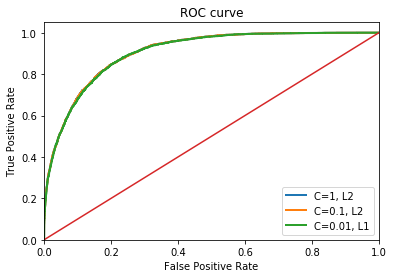

In [59]:
# отрисовка ROC-кривой
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, pred2[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, pred3[:,1])
lw = 2
plt.plot(fpr, tpr, lw=lw, label='C=1, L2')
plt.plot(fpr2, tpr2, lw=lw, label='C=0.1, L2')
plt.plot(fpr3, tpr3, lw=lw, label='C=0.01, L1')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend( loc = 0 )
plt.title('ROC curve')
plt.show()

In [60]:
from sklearn.metrics import roc_auc_score
print('AUC-ROC C=1, L2:',roc_auc_score(y_test, pred[:,1]))
print('AUC-ROC C=0.1, L2:',roc_auc_score(y_test, pred2[:,1]))
print('AUC-ROC C=0.01, L1:',roc_auc_score(y_test, pred3[:,1]))

AUC-ROC C=1, L2: 0.9058656185309364
AUC-ROC C=0.1, L2: 0.9057797061864475
AUC-ROC C=0.01, L1: 0.904575241267296


2. knn

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
from sklearn.model_selection import GridSearchCV

In [66]:
param = {'n_neighbors': list(range(1, 11)), 'weights': ['uniform', 'distance']}

In [67]:
# gs = GridSearchCV(KNeighborsClassifier(), param_grid = param, scoring = 'accuracy', return_train_score = False )

In [ ]:
# gs.fit(X_train, y_train)

In [ ]:
# gs.best_params_

In [69]:
clf = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')

In [70]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [71]:
pred = clf.predict_proba(X_test)

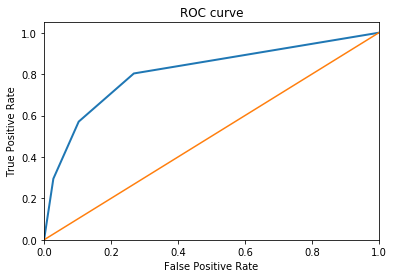

In [72]:
# отрисовка ROC-кривой
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred[:,1])
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [73]:
from sklearn.metrics import roc_auc_score
print('AUC-ROC:',roc_auc_score(y_test, pred[:,1]))

AUC-ROC: 0.8098619577574822


3. Случайный лес

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
clf = RandomForestClassifier(max_depth = 10)

In [86]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
pred = clf.predict_proba(X_test)

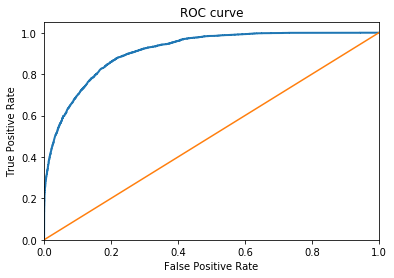

In [88]:
# отрисовка ROC-кривой
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred[:,1])
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [89]:
from sklearn.metrics import roc_auc_score
print('AUC-ROC:',roc_auc_score(y_test, pred[:,1]))

AUC-ROC: 0.9120918535510129
